In [145]:
import numpy as np
import pandas as pd

# Data loading (Step (a))

In [146]:
class mnist_loader:    
    def __init__(self):
        pass
            
    def load_labels(self, filename):
        # MNIST labels are stored as a 1D array of bytes.
        
        with open(filename, 'rb') as f:
            print(f"Reading data from {filename}...")
            
            # First 4 bytes = "magic number", which we don't need
            # Next 4 bytes = Number of labels, which we also don't need, because the rest of the file is just 1-byte integers
            f.seek(8)
            
            labels = np.frombuffer(f.read(), dtype=np.uint8)
            print(f"Read {len(labels)} labels.")
    
        return labels
    
    def load_images(self, filename):
        # MNIST images are stored as a 2D array of bytes, with each row representing an image.
        
        with open(filename, 'rb') as f:
            print(f"Reading data from {filename}...")
            
            # First 4 bytes = "magic number", which we can skip
            # Next 4 bytes = Number of images
            # Next 4 bytes = Number of rows
            # Next 4 bytes = Number of columns
            _, num_images, num_rows, num_cols = np.frombuffer(f.read(16), dtype='>i4')
            
            images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
            print(f"Read {images.shape[0]} images with shape {num_rows}x{num_cols}.")
            
        return images
    
    
def load_training_data():
    loader = mnist_loader()
    train_labels = loader.load_labels('mnist/train-labels.idx1-ubyte')
    train_images = loader.load_images('mnist/train-images.idx3-ubyte')

    return train_labels, train_images

def load_test_data():
    loader = mnist_loader()
    test_labels = loader.load_labels('mnist/t10k-labels.idx1-ubyte')
    test_images = loader.load_images('mnist/t10k-images.idx3-ubyte')

    return test_labels, test_images

# Implementation of neural network and multicategory PTA (Steps (b)-(d))

In [147]:
class NeuralNetwork:
    def __init__(self, weights_shape):
        self.weights = np.zeros(shape=weights_shape)
        self.step_function = lambda x: np.heaviside(x, 1)

    def multicategory_predict(self, inputs_X):
        local_fields = self.weights @ inputs_X
        outputs_Y = np.argmax(local_fields)
        return outputs_Y

    def multicategory_update(self, inputs_X, labels_d, learning_rate):
        for input_x, label_d in zip(inputs_X, labels_d):
            output_y = self.step_function(self.weights @ input_x)
            
            # label_d - output_y has shape (10,)
            # input_x has shape (784,)
            # Use np.newaxis to align dimensions for broadcasting
            self.weights += learning_rate * (label_d - output_y)[:, np.newaxis] * input_x[np.newaxis, :]
        
    def multicategory_pta(self, inputs_X, labels_d, learning_rate=0.01, epsilon=1e-5, seed=None):
        # Set up rng
        if seed is not None:
            rng = np.random.default_rng(seed)
        else:
            rng = np.random.default_rng()
        
        # Randomly initialize weights
        self.weights = rng.uniform(-0.01, 0.01, size=self.weights.shape)
        
        # Report initial accuracy
        num_epochs = 0
        errors_per_epoch = []
        
        accuracy, errors = self.multicategory_accuracy(inputs_X, labels_d)
        errors_per_epoch.append(errors)
        print(f"Epoch {num_epochs}:\t{errors} errors on {len(labels_d)} samples, accuracy {accuracy * 100:.4f}%")

        # Convert scalar labels to one-hot encoded vectors
        label_vectors_d = np.zeros((len(labels_d), self.weights.shape[0]))
        label_vectors_d[np.arange(len(labels_d)), labels_d] = 1

        # Perform training until accuracy threshold is met
        while (errors / len(labels_d)) > epsilon:
            num_epochs += 1
            
            # Iterate over examples and update weights
            self.multicategory_update(inputs_X, label_vectors_d, learning_rate)
            
            # Report accuracy at end of epoch
            accuracy, errors = self.multicategory_accuracy(inputs_X, labels_d)
            errors_per_epoch.append(errors)
            print(f"Epoch {num_epochs}:\t{errors} errors on {len(labels_d)} samples, accuracy {accuracy * 100:.4f}%")
        
        return errors_per_epoch
    
    def multicategory_test(self, inputs_X, labels_d):
        accuracy, errors = self.multicategory_accuracy(inputs_X, labels_d)
        print(f"Test set:\t{errors} errors on {len(labels_d)} samples, accuracy {accuracy * 100:.4f}%")
        return accuracy, errors
        
    def multicategory_accuracy(self, inputs_X, labels_d):
        outputs_Y = [self.multicategory_predict(inputs) for inputs in inputs_X]
        errors = sum(output_y != label_d for output_y, label_d in zip(outputs_Y, labels_d))
        accuracy = (len(labels_d) - errors) / len(labels_d)
        
        return accuracy, errors

# Experiments (Steps (e)-(h))

In [148]:
seed = 1234

# Load data
train_labels, train_inputs = load_training_data()    
test_labels, test_inputs = load_test_data()

# Create neural network
nn = NeuralNetwork((10, 784))

Reading data from mnist/train-labels.idx1-ubyte...
Read 60000 labels.
Reading data from mnist/train-images.idx3-ubyte...
Read 60000 images with shape 28x28.
Reading data from mnist/t10k-labels.idx1-ubyte...
Read 10000 labels.
Reading data from mnist/t10k-images.idx3-ubyte...
Read 10000 images with shape 28x28.


In [149]:
def run_experiment(N, eta, epsilon, seed=None):
    training_errors = nn.multicategory_pta(train_inputs[:N], train_labels[:N], learning_rate=eta, epsilon=epsilon, seed=seed)
    test_accuracy, test_errors = nn.multicategory_test(test_inputs, test_labels)
    return training_errors, test_accuracy, test_errors

def plot_training_errors(training_errors, N, eta, epsilon):
    import matplotlib.pyplot as plt
    
    plt.figure()
    plt.plot(training_errors, marker='o')
    plt.title(f'Training Errors vs Epochs (N={N}, eta={eta}, epsilon={epsilon})')
    plt.xlabel('Epoch')
    plt.ylabel('Number of Errors')
    plt.grid(True)
    plt.show()

## Step (e)

The final training accuracy is 100%, but the test accuracy is only 55%. When training, the weights are adjusted just until all the training samples are exactly classified. Ideally, training data is statistically similar to test data, and so the solution derived from training data is also a suitable solution for test data. But when the amount of training data is relatively small, we are less likely to have captured the behavior of the test data. As we can see here, a solution which works for a specific set of 50 samples does not generalize very well to all samples.

Epoch 0:	42 errors on 50 samples, accuracy 16.0000%
Epoch 1:	13 errors on 50 samples, accuracy 74.0000%
Epoch 2:	3 errors on 50 samples, accuracy 94.0000%
Epoch 3:	3 errors on 50 samples, accuracy 94.0000%
Epoch 4:	0 errors on 50 samples, accuracy 100.0000%
Test set:	4427 errors on 10000 samples, accuracy 55.7300%


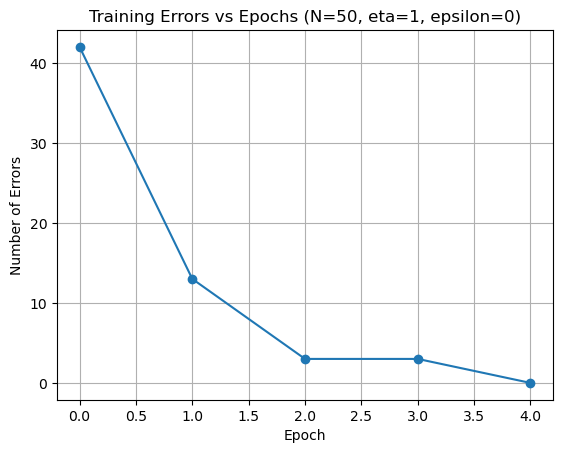

In [150]:
# Test 1 (Step (e))
training_errors, test_accuracy, test_errors = run_experiment(N=50, eta=1, epsilon=0, seed=seed)
plot_training_errors(training_errors, N=50, eta=1, epsilon=0)

## Step (f)

With 1000 training samples, we again manage a training accuracy of 100%, but the test accuracy is still only 82%. This is, of course, better than the 55% test accuracy we saw in step (e). This demonstrates that increasing the number of training samples increases the quality of our solution; having more training examples gives us a better impression of the data is like in general, and not just what those specific samples are like.

Epoch 0:	821 errors on 1000 samples, accuracy 17.9000%
Epoch 1:	167 errors on 1000 samples, accuracy 83.3000%
Epoch 2:	166 errors on 1000 samples, accuracy 83.4000%
Epoch 3:	90 errors on 1000 samples, accuracy 91.0000%
Epoch 4:	145 errors on 1000 samples, accuracy 85.5000%
Epoch 5:	66 errors on 1000 samples, accuracy 93.4000%
Epoch 6:	96 errors on 1000 samples, accuracy 90.4000%
Epoch 7:	48 errors on 1000 samples, accuracy 95.2000%
Epoch 8:	64 errors on 1000 samples, accuracy 93.6000%
Epoch 9:	27 errors on 1000 samples, accuracy 97.3000%
Epoch 10:	45 errors on 1000 samples, accuracy 95.5000%
Epoch 11:	24 errors on 1000 samples, accuracy 97.6000%
Epoch 12:	61 errors on 1000 samples, accuracy 93.9000%
Epoch 13:	20 errors on 1000 samples, accuracy 98.0000%
Epoch 14:	19 errors on 1000 samples, accuracy 98.1000%
Epoch 15:	26 errors on 1000 samples, accuracy 97.4000%
Epoch 16:	21 errors on 1000 samples, accuracy 97.9000%
Epoch 17:	18 errors on 1000 samples, accuracy 98.2000%
Epoch 18:	22 err

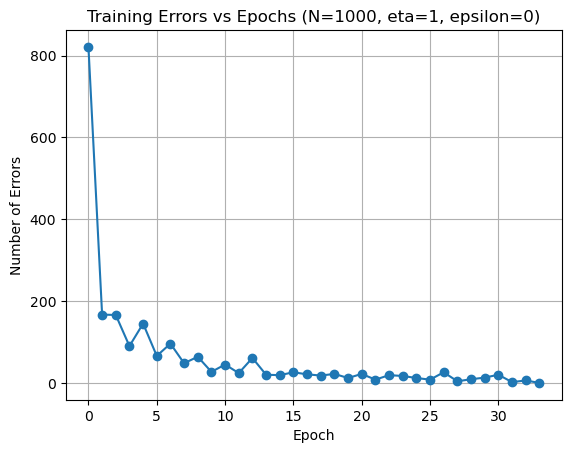

In [151]:
# Test 2 (Step (f))
training_errors, test_accuracy, test_errors = run_experiment(N=1000, eta=1, epsilon=0, seed=seed)
plot_training_errors(training_errors, N=1000, eta=1, epsilon=0)

## Step (g)

The following experiment uses all 60,000 training samples. With $\epsilon$=0, the weights do not converge. Accuracy hovers around 85%.

Now we have a scenario where the training data cannot be 100% accurately classified. Our 2-layer architecture is quite simple, and this result suggests that the function which would correctly classify all of these samples is more complex than what this architecture can approximate.


In [152]:
# Test 3 (Step (g))
# training_errors, test_accuracy, test_errors = run_experiment(N=60000, eta=1, epsilon=0, seed=seed)

## Step (h)

Based on our observation that training accuracy approaches 85% with $\epsilon=0$, we set $\epsilon=0.15$ to get relatively fast convergence. (We could probably still get convergence with a slightly lower $\epsilon$, as rates of 86% or even once 87% were observed, but then we (and you, the grader) would have to sit here for 2+ minutes waiting for that to happen.)

Weights are randomly generated every time we begin training, and so three different sets of weights are chosen by passing three different seeds to the random number generator.

|           | Final training accuracy | Test accuracy |
|-----------|-------------------------|---------------|
| Weights 1 | 85.1367%                | 84.6100%      |
| Weights 2 | 86.5133%                | 86.1000%      |
| Weights 3 | 85.6833%                | 85.0700%      |

In step (f) we used 1000 training samples and got a test accuracy of 82%. Now we train with 60,000 training samples to the best accuracy we can, and the resulting test accuracy is only 2-4% better. This demonstrates that there are apparently diminishing returns when increasing the number of samples used to train the same architecture. The 2-4% increase in performance isn't *bad*, certainly, but if you went out and got another 60,000 training samples, it would probably not be worth the time and effort.

It's also interesting to note that this mirrors a pattern we can see within each experiment, where initial adjustments to the weights result in large boosts in accuracy, and as the number of epochs goes on, the changes in accuracy become smaller. Of course, that's happening because as accuracy increases, the number of adjustments to the weights in each epoch goes down; so we see similar phenomena occuring for different reasons.

Epoch 0:	49153 errors on 60000 samples, accuracy 18.0783%
Epoch 1:	9478 errors on 60000 samples, accuracy 84.2033%
Epoch 2:	10212 errors on 60000 samples, accuracy 82.9800%
Epoch 3:	9425 errors on 60000 samples, accuracy 84.2917%
Epoch 4:	9720 errors on 60000 samples, accuracy 83.8000%
Epoch 5:	8918 errors on 60000 samples, accuracy 85.1367%
Test set:	1539 errors on 10000 samples, accuracy 84.6100%


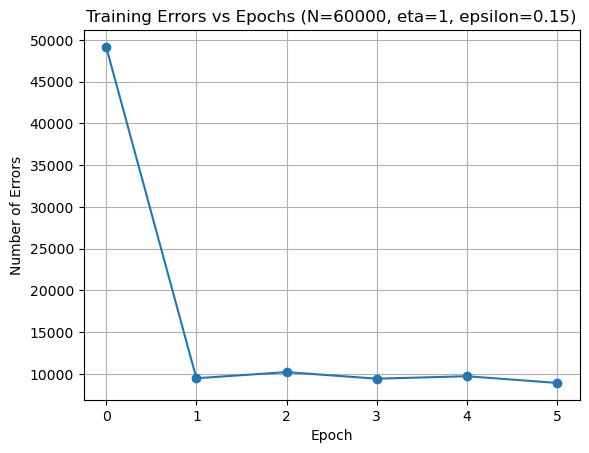

Epoch 0:	54507 errors on 60000 samples, accuracy 9.1550%
Epoch 1:	9660 errors on 60000 samples, accuracy 83.9000%
Epoch 2:	9602 errors on 60000 samples, accuracy 83.9967%
Epoch 3:	10078 errors on 60000 samples, accuracy 83.2033%
Epoch 4:	9758 errors on 60000 samples, accuracy 83.7367%
Epoch 5:	8092 errors on 60000 samples, accuracy 86.5133%
Test set:	1390 errors on 10000 samples, accuracy 86.1000%


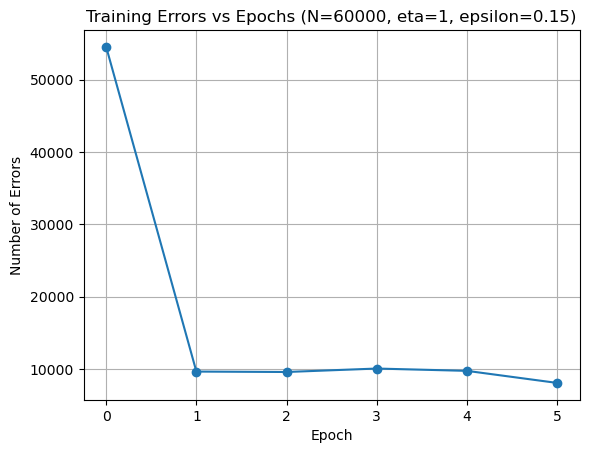

Epoch 0:	51535 errors on 60000 samples, accuracy 14.1083%
Epoch 1:	9073 errors on 60000 samples, accuracy 84.8783%
Epoch 2:	9248 errors on 60000 samples, accuracy 84.5867%
Epoch 3:	11271 errors on 60000 samples, accuracy 81.2150%
Epoch 4:	10198 errors on 60000 samples, accuracy 83.0033%
Epoch 5:	10433 errors on 60000 samples, accuracy 82.6117%
Epoch 6:	9928 errors on 60000 samples, accuracy 83.4533%
Epoch 7:	9625 errors on 60000 samples, accuracy 83.9583%
Epoch 8:	10117 errors on 60000 samples, accuracy 83.1383%
Epoch 9:	9276 errors on 60000 samples, accuracy 84.5400%
Epoch 10:	10426 errors on 60000 samples, accuracy 82.6233%
Epoch 11:	8590 errors on 60000 samples, accuracy 85.6833%
Test set:	1493 errors on 10000 samples, accuracy 85.0700%


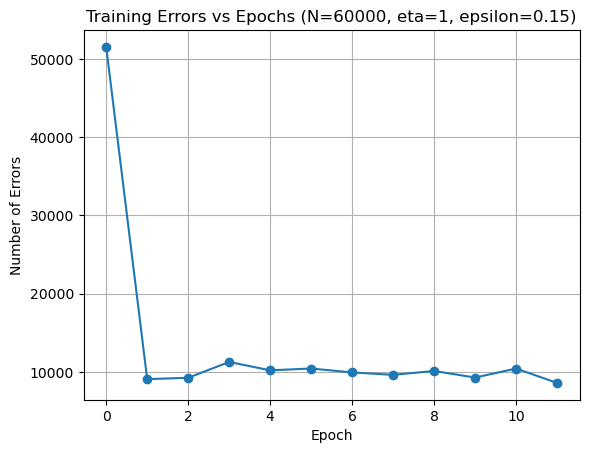

In [153]:
# Test 4 (Step (h))
for seed in [1234, 5678, 91011]:
    training_errors, test_accuracy, test_errors = run_experiment(N=60000, eta=1, epsilon=0.15, seed=seed)
    plot_training_errors(training_errors, N=60000, eta=1, epsilon=0.15)